In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def jac(model, x):
    f = lambda x: model(x)
    return jax.jacrev(f)(x)
jac = vmap(jac, (None, 0))

In [26]:
class mlp(nnx.Module):
    def __init__(self, p, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(p, p, rngs=rngs)
        self.linear2 = nnx.Linear(p, p, rngs=rngs)
#         self.linear3 = nnx.Linear(p, p, rngs=rngs)
#         self.linear4 = nnx.Linear(p, p, rngs=rngs)
#         self.linear0 = nnx.Linear(p, p, rngs=rngs)
    def __call__(self, x):
#         x_in = x
        x = self.linear1(x)
        x = nnx.tanh(x)
        x = self.linear2(x)
        # x = nnx.tanh(x)
        # x = x + self.linear3(x)
        # x = nnx.tanh(x)
        # x = x + self.linear4(x)
        return x
        
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        jacobian = jnp.diff(jac(model, x), axis = 0)
        # pen = 10*jnp.mean(jnp.abs(jacobian))
        return jnp.mean((y_pred - y)**2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

In [27]:
# class mlp(nnx.Module):
#     def __init__(self, p, rngs: nnx.Rngs):
#         self.lin1 = nnx.Linear(p, p//2, rngs=rngs)
#         self.lin2 = nnx.Linear(p//2, p//2, rngs=rngs)
#         self.lin3 = nnx.Linear(p//2, p, rngs=rngs)
#     def __call__(self, x):
#         x = self.lin1(x)
#         x = nnx.relu(x)
#         x = self.lin2(x)
#         x = nnx.relu(x)
#         x = self.lin3(x)
#         return x

In [97]:
rng = random.key(2)
n, p = 5000, 10

theta = np.diag(np.zeros(p))
idx = random.bernoulli(rng, 0.1, (p, p))
theta[idx] = 0.2

x = np.array(random.normal(rng, (n, p)))

for i in range(1, n):
    x[i] = theta @ x[i-1] + x[i]
    
y = x[1:]
x = x[:-1]

In [98]:
model1 = mlp(p = p, rngs = nnx.Rngs(0))
optim = nnx.Optimizer(model1, optax.adam(1e-2))
trace = []
for _ in trange(1000):
    loss = train_step(model1, optim, x, y)
    trace.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [99]:
jfull1 = jac(model1, x)

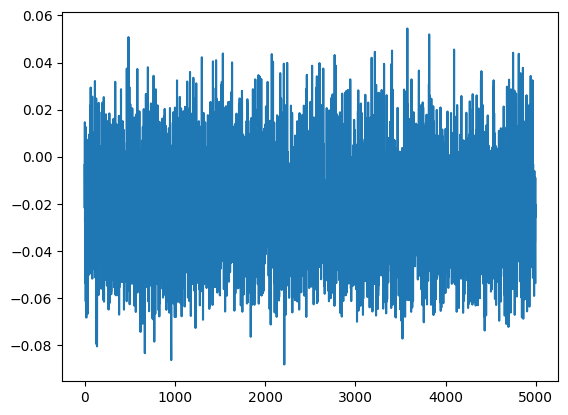

In [100]:
plt.plot(jfull1[:,1,4])

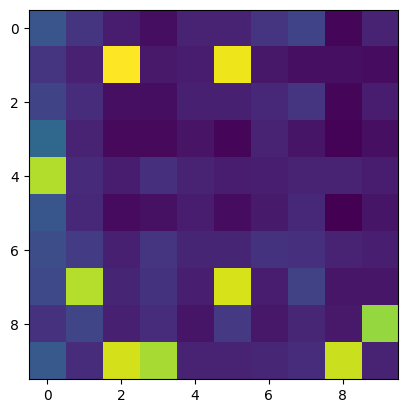

In [101]:
jfull1 = jac(model1, x)
jhat1 = jnp.median(jnp.abs(jfull1), axis = 0)
plt.imshow(jhat1)

In [102]:
rng = random.PRNGKey(1234)
r = np.array(random.normal(rng, (n, p)))
ry = r[1:]
rx = r[:-1]

In [103]:
model2 = mlp(p = p, rngs = nnx.Rngs(0))
optim = nnx.Optimizer(model2, optax.adam(1e-2))
trace = []
for _ in trange(1000):
    loss = train_step(model2, optim, rx, ry)
    trace.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

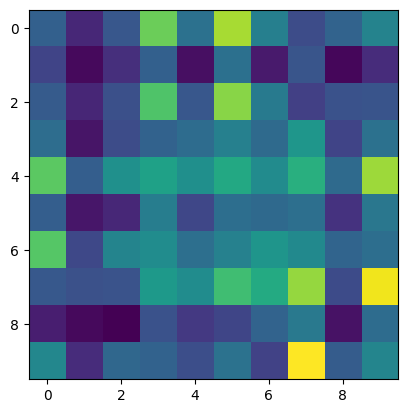

In [104]:
jfull2 = jac(model2, x)
jhat2 = jnp.median(np.abs(jfull2), axis = 0)
plt.imshow(jhat2)

In [105]:
# jhat2 += jnp.median(jhat2)

In [106]:
alpha = 0.05
t = jnp.linspace(0, 2, p**2)
fdp = []
for i in trange(len(t)):
    fdp = np.sum(jhat2 >= t[i])/np.sum(jhat1 >= t[i])
    if fdp <= alpha:
        break
tq = t[i]
tq

  0%|          | 0/100 [00:00<?, ?it/s]

Array(0.08080808, dtype=float32)

In [107]:
# tq = t[np.argmax(np.array(fdp) <= alpha)]

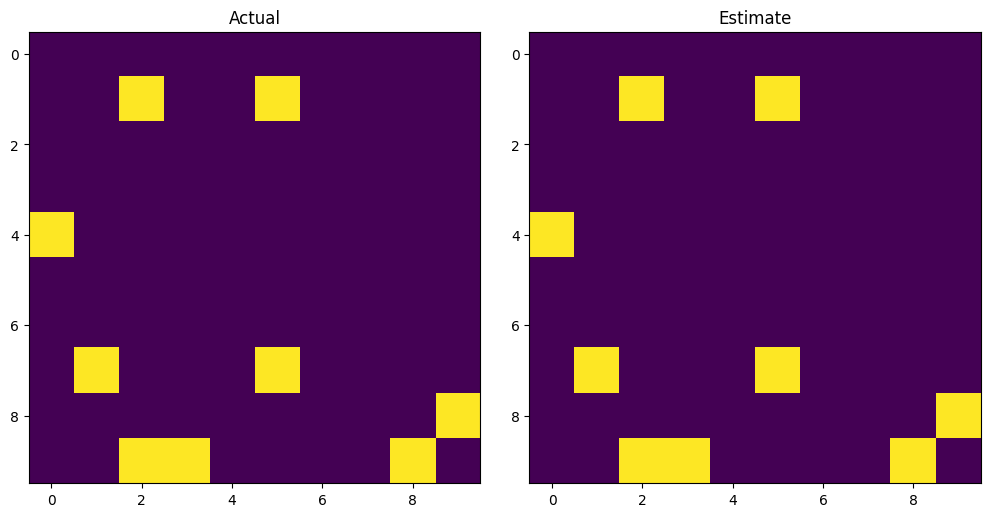

In [108]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 5))
ax[0].imshow(theta)
ax[0].set_title('Actual')
ax[1].imshow(jhat1 >= tq)
ax[1].set_title('Estimate')
plt.show()

In [109]:
theta_int = 1.0*(jnp.abs(theta) > 0)
theta_hat = 1.0*(jhat1 >= tq)

In [110]:
jnp.mean(theta_int == theta_hat)

Array(1., dtype=float32)

In [111]:
jnp.mean(theta_int[theta_int == 0] == theta_hat[theta_int == 0])

Array(1., dtype=float32)

In [112]:
jnp.mean(theta_int[theta_int == 1] == theta_hat[theta_int == 1])

Array(1., dtype=float32)

In [113]:
jnp.mean(theta_int[theta_hat == 1] == theta_hat[theta_hat == 1])

Array(1., dtype=float32)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulate interacting multivariate time series
def true_dynamics(t, y):
    y1, y2, y3 = y[0], y[1], y[2]
    dy1 = -0.1 * y1 + 0.5 * y2 * y3
    dy2 = -y2 + torch.sin(y1)
    dy3 = y1 * y2 - 0.3 * y3
    return torch.stack([dy1, dy2, dy3])

t = torch.linspace(0., 10., 200).to(device)   # time points
y0 = torch.tensor([1.0, 0.5, -1.0], device=device)  # initial condition

with torch.no_grad():
    y_data = [y0]
    dt = t[1] - t[0]
    for _ in range(1, len(t)):
        y_next = y_data[-1] + dt * true_dynamics(None, y_data[-1])
        y_data.append(y_next)
    y_data = torch.stack(y_data) + 0.1 * torch.randn_like(torch.stack(y_data))  # add noise

In [4]:
class ODEF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.Tanh(),
            nn.Linear(64, dim),
        )

    def forward(self, t, y):
        # concat y with time for time-aware dynamics
        t_expanded = torch.ones(y.shape[0], 1).to(y) * t
        inp = torch.cat([y, t_expanded], dim=1)
        return self.net(inp)

In [1]:
class NeuralODE(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, y0, t):
        return odeint(self.odefunc, y0, t)

# Wrap inputs
y_data = y_data.to(device)
y0_train = y_data[0].unsqueeze(0)  # shape: (1, 3)

odefunc = ODEF(dim=3).to(device)
model = NeuralODE(odefunc).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-1)

loss_fn = nn.MSELoss()

for epoch in trange(500):
    optimizer.zero_grad()
    pred_y = model(y0_train, t).squeeze(1)  # shape: (T, 3)
    loss = loss_fn(pred_y, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

In [ ]:
yhat = model(y0_train, t).squeeze().detach().cpu()
plt.plot(y_data.cpu(), alpha = 0.5)
plt.plot(yhat)
plt.show()

In [22]:
yhat = model(y0_train, t).squeeze().detach().cpu()
ynoise = model(y0_train + 0.2 * torch.Tensor([1, 0, 1]).cuda(), t).squeeze().detach().cpu()

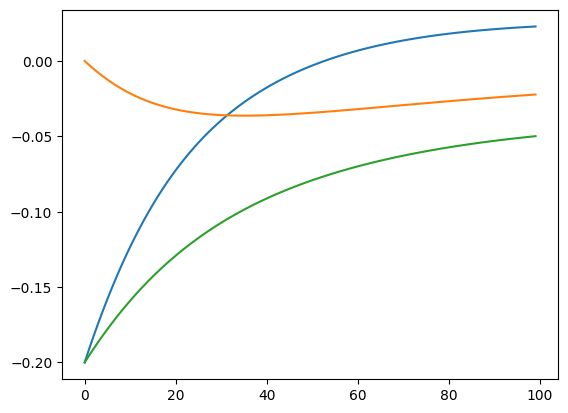

In [23]:
plt.plot((yhat - ynoise))
plt.show()

In [4]:
def mutual_info(x, y):
    z = jnp.concat([x, y], axis = 1)
    
    sig_x = jnp.cov(x.T)
    sig_y = jnp.cov(y.T)
    sig_z = jnp.cov(z.T)

    det_x = jnp.linalg.det(sig_x)
    det_y = jnp.linalg.det(sig_y)
    det_z = jnp.linalg.det(sig_z)

    return 0.5 * jnp.log((det_x * det_y) / det_z)
mutual_info = jit(mutual_info)

In [88]:
rng = random.PRNGKey(678)
n, p = 2000, 2

rng = random.PRNGKey(1)
key1, key2 = random.split(rng, 2)
x = random.normal(key1, (n//2, p))
y = random.normal(key2, (n//2, p))

mi_ind = mutual_info(x, y)
mi_ind

Array(0.00291029, dtype=float32)

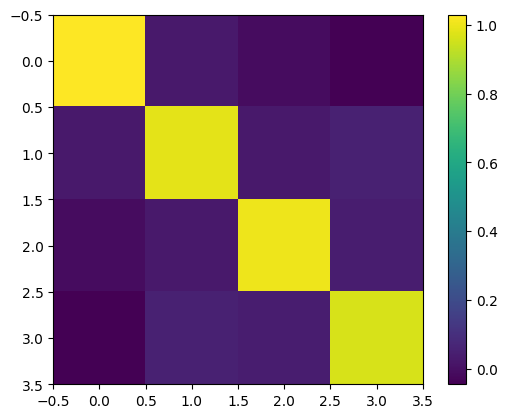

In [89]:
z = jnp.concat([x, y], axis = 1)
sig_z = jnp.cov(z.T)
det_z = jnp.linalg.det(sig_z)
plt.imshow(sig_z)
plt.colorbar()

In [79]:
rng = random.PRNGKey(0)

In [80]:
# ar process
theta_x = 0.2
theta_y = 0.2

x = np.zeros((n, p))
y = np.zeros((n, p))

x[i] = random.normal(key1, (1, p))
y[i] = random.normal(key2, (1, p))

for i in trange(1, n):
    rng, key1, key2 = random.split(rng, 3)
    x[i] = theta_x * x[i-1] + random.normal(key1, (1, p))
    y[i] = theta_y * y[i-1] + random.normal(key2, (1, p))

x = x[(n//2):]
y = y[(n//2):]

  0%|          | 0/1999 [00:00<?, ?it/s]

In [81]:
mi_dep = mutual_info(x, y)
mi_dep

Array(0.00840791, dtype=float32)

In [82]:
mi_dep/mi_ind

Array(2.889024, dtype=float32)

In [83]:
z = jnp.concat([x, y], axis = 1)
sig_z = jnp.cov(z.T)
det_z = jnp.linalg.det(sig_z)

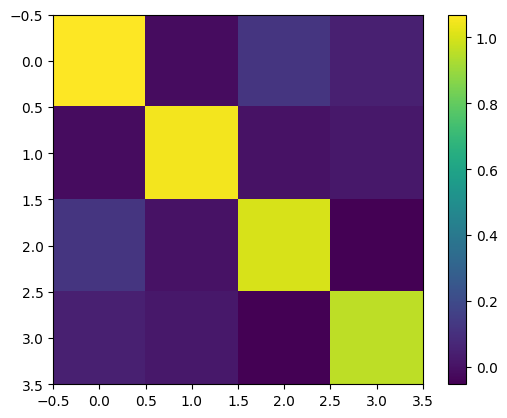

In [87]:
plt.imshow(sig_z)
plt.colorbar()

In [323]:
import os
os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [72]:
dtrain = np.load('../data/temp_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

# def clim_smooth(data, kernel):
#     return jax.scipy.signal.convolve2d(data, kernel, mode='same')
# clim_smooth = jit(vmap(clim_smooth, (0, None)))

# kernel = jnp.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]])
# kernel = kernel / jnp.sum(kernel)
# dtrain = np.array(clim_smooth(dtrain, kernel))

In [73]:
dtrain = jax.image.resize(dtrain, (dtrain.shape[0], 12, 24), method = 'bicubic')
dtrain = jnp.mean(dtrain[:121*30].reshape(-1, 30, 12, 24), axis = 1)

lag, lead = 12, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
xtrain = np.moveaxis(xtrain, 1, 3)
ytrain = np.moveaxis(ytrain, 1, 3)
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

In [137]:
epochs = 500
width = 50
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model = DeepANO(lag, width, lead, rngs=model_rng)
optim = nnx.Optimizer(model, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

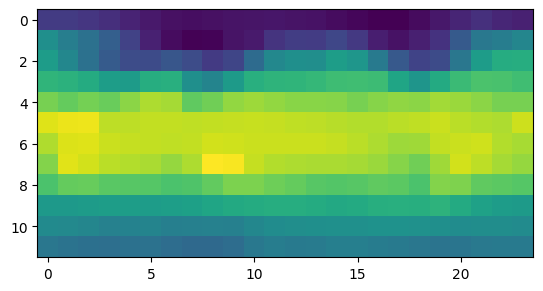

In [138]:
plt.imshow(model(xtrain[0:1]).squeeze())

In [69]:
def spatial_jac(model, x):
    def f(x):
        x = x.reshape(1, 12, 24, 12)
        yhat = model(x)
        return yhat.reshape(-1)
    return jax.jacrev(f)(x)
spatial_jac = vmap(spatial_jac, (None, 0))

In [148]:
jfull = spatial_jac(model, xtrain.reshape(109, -1))
jhat1 = jnp.mean(jfull, axis = 0).reshape(12*24, 12*24, 12)
jmax1 = jnp.max(jnp.abs(jhat1), axis = 2)
jmax1.shape

(288, 288)

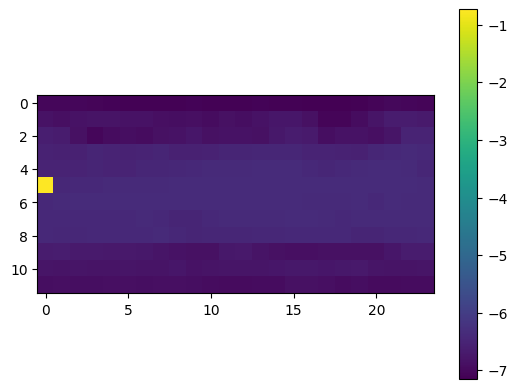

In [149]:
plt.imshow(jnp.log(jmax1[120]).reshape(12, 24))
plt.colorbar()
plt.show()

In [144]:
dtest = jax.random.normal(rng, dtrain.shape)
lag, lead = 12, 1
xtest, ytest = split_data(dtest, lag, lead)
xtest = np.moveaxis(xtest, 1, 3)
ytest = np.moveaxis(ytest, 1, 3)
test_data = TensorDataset(torch.Tensor(xtest), torch.Tensor(ytest))
test_loader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [145]:
epochs = 500
width = 50
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model2 = DeepANO(lag, width, lead, rngs=model_rng)
optim = nnx.Optimizer(model2, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in test_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        loss = train_step(model2, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

In [129]:
jax.random.normal(rng, dtrain.shape).shape

(121, 12, 24)

In [146]:
jbase = spatial_jac(model2, xtest.reshape(109, -1))
jhat2 = jnp.mean(jbase, axis = 0).reshape(12*24, 12*24, 12)
jmax2 = jnp.max(jnp.abs(jhat2), axis = 2)
jmax2.shape

(288, 288)

In [151]:
alpha = 0.05
t = jnp.linspace(0, 2, 12*24)
fdp = []
for i in trange(len(t)):
    fdp = np.sum(jmax2 >= t[i])/np.sum(jmax1 >= t[i])
    if fdp <= alpha:
        break
tq = t[i]
tq

  0%|          | 0/288 [00:00<?, ?it/s]

Array(0.1533101, dtype=float32)

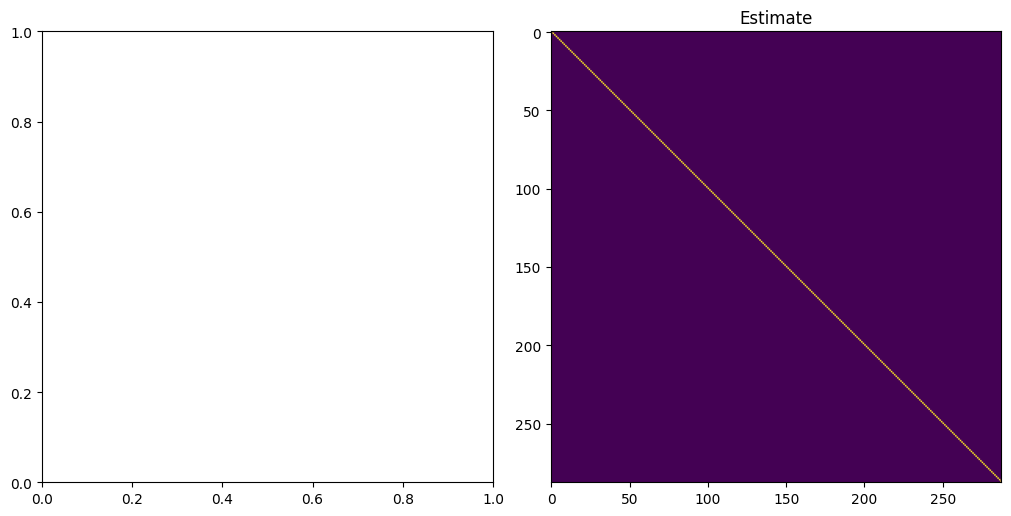

In [153]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 5))
ax[1].imshow(jmax1 >= tq)
ax[1].set_title('Estimate')
plt.show()

In [62]:
class DeepANO(nnx.Module):
    def __init__(self, rngs):
        self.encode_layer = nnx.Conv(12, 32, (3, 5), padding = 'SAME', rngs=rngs)
        self.ano1 = nnx.Conv(32, 32, (3, 5), padding = 'SAME', rngs=rngs)
        self.ano2 = nnx.Conv(32, 32, (3, 5), padding = 'SAME', rngs=rngs)
        self.ano3 = nnx.Conv(32, 32, (3, 5), padding = 'SAME',  rngs=rngs)
        self.ano4 = nnx.Conv(32, 32, (3, 5), padding = 'SAME', rngs=rngs)
        self.ano5 = nnx.Conv(32, 32, (3, 5), padding = 'SAME',  rngs=rngs)
        self.decode_layer = nnx.Conv(32, 1, (3, 5), padding = 'SAME',  rngs=rngs)

    def __call__(self, x):
        x0 = self.encode_layer(x)
        x1 = self.ano1(x0)
        x2 = self.ano2(x1)
        x3 = x2 + self.ano3(x2)
        x4 = x1 + self.ano4(x3)
        x5 = x0 + self.ano5(x4)
        x6 = self.decode_layer(x5)
        return x6

In [63]:
epochs = 500
width = 50
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model = DeepANO(rngs=model_rng)
optim = nnx.Optimizer(model, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

In [68]:
xtrain.shape

(120, 1, 12, 24)

In [70]:
jfull = spatial_jac(model, xtrain.reshape(120, -1))
jhat1 = jnp.mean(jfull, axis = 0).reshape(12*24, 12*24, 12)
jmax1 = jnp.max(jnp.abs(jhat1), axis = 2)
jmax1.shape

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 1 // 1 != 12.

In [ ]:
plt.imshow(jmax1[20].reshape(12, 24))
plt.colorbar()
plt.show()

In [25]:
dtest = jax.random.normal(rng, dtrain.shape)
lag, lead = 12, 1
xtest, ytest = split_data(dtest, lag, lead)
xtest = np.moveaxis(xtest, 1, 3)
ytest = np.moveaxis(ytest, 1, 3)
test_data = TensorDataset(torch.Tensor(xtest), torch.Tensor(ytest))
test_loader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [26]:
epochs = 500
width = 50
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model2 = DeepANO(rngs=model_rng)
optim = nnx.Optimizer(model2, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        loss = train_step(model2, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

In [27]:
jbase = spatial_jac(model2, xtest.reshape(109, -1))
jhat2 = jnp.mean(jbase, axis = 0).reshape(12*24, 12*24, 12)
jmax2 = jnp.max(jnp.abs(jhat2), axis = 2)
jmax2.shape

(288, 288)

In [28]:
alpha = 0.05
t = jnp.linspace(0, 2, 12*24)
fdp = []
for i in trange(len(t)):
    fdp = np.sum(jmax2 >= t[i])/np.sum(jmax1 >= t[i])
    if fdp <= alpha:
        break
tq = t[i]
tq

  0%|          | 0/288 [00:00<?, ?it/s]

Array(2., dtype=float32)

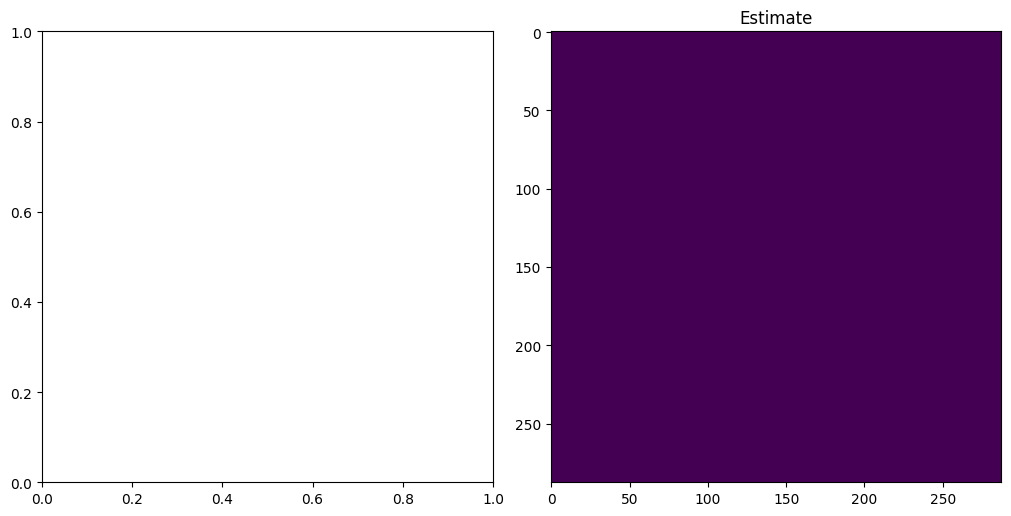

In [29]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 5))
ax[1].imshow(jmax1 >= tq)
ax[1].set_title('Estimate')
plt.show()

In [103]:
class DeepANO(nnx.Module):
    def __init__(self, rngs):
        self.encode_layer = nnx.Linear(288, 32, rngs=rngs)
        self.ano1 = nnx.Linear(32, 32, rngs=rngs)
        self.ano2 = nnx.Linear(32, 32, rngs=rngs)
        self.ano3 = nnx.Linear(32, 32, rngs=rngs)
        self.decode_layer = nnx.Linear(32, 288, rngs=rngs)

    def __call__(self, x):
        x0 = self.encode_layer(x)
        x1 = self.ano1(x0)
        x2 = x1 + self.ano2(x1)
        x3 = x0 + self.ano3(x2)
        x4 = self.decode_layer(x3)
        return x4

In [107]:
def spatial_jac(model, x):
    def f(x):
        yhat = model(x)
        return yhat.squeeze()
    return jax.jacrev(f)(x)
spatial_jac = vmap(spatial_jac, (None, 0))

In [105]:
epochs = 500
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model = DeepANO(rngs=model_rng)
optim = nnx.Optimizer(model, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt).reshape(xt.shape[0], -1)
        yt = torch2jax(yt).reshape(yt.shape[0], -1)
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

In [108]:
jfull = spatial_jac(model, xtrain.reshape(120, -1))
jhat = jnp.mean(jfull, axis = 0)

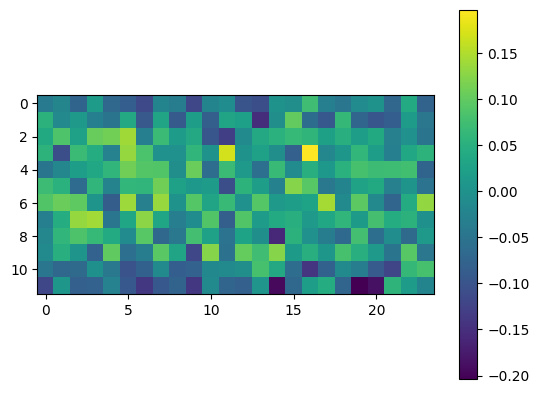

In [110]:
plt.imshow(jhat[:,64].reshape(12, 24))
plt.colorbar()
plt.show()

In [6]:
class DeepANO(nnx.Module):
    def __init__(self, rngs):
        self.encode_layer = nnx.MultiHeadAttention(num_heads=8, in_features=1, qkv_features=16,
                               decode=False, rngs=nnx.Rngs(0))

    def __call__(self, x):
        x = self.encode_layer(x)
        return x

In [7]:
epochs = 50
rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)

model = DeepANO(rngs=model_rng)
optim = nnx.Optimizer(model, optax.adam(1e-3))
trace = []
for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt).reshape(xt.shape[0], -1, 1)
        yt = torch2jax(yt).reshape(yt.shape[0], -1, 1)
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
def spatial_jac(model, x):
    def f(x):
        x = x.reshape(1, 12*24, 1)
        yhat = model(x)
        return yhat.reshape(-1)
    return jax.jacrev(f)(x)
spatial_jac = vmap(spatial_jac, (None, 0))

In [ ]:
jfull = spatial_jac(model, xtrain.reshape(120, -1))
jhat = jnp.mean(jfull, axis = 0)